In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import cv2
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

image_folder_path = '/content/drive/My Drive/images_class/'

if not os.path.exists(image_folder_path):
    print(f"Error: Folder not found at {image_folder_path}")
else:
    class_folders = os.listdir(image_folder_path)

    dataset = []
    for class_name in class_folders:
        class_path = os.path.join(image_folder_path, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for image_file in image_files:
                full_path = os.path.join(class_path, image_file)
                dataset.append((full_path, class_name))

    # Print summary
    print(f"Total images found: {len(dataset)}")
    for i, (path, label) in enumerate(dataset[:10]):
        print(f"{i+1}. {label} --> {path}")


Total images found: 60
1. davido --> /content/drive/My Drive/images_class/davido/image01.jpeg
2. davido --> /content/drive/My Drive/images_class/davido/image02.jpeg
3. davido --> /content/drive/My Drive/images_class/davido/image03.jpeg
4. davido --> /content/drive/My Drive/images_class/davido/image04.jpeg
5. davido --> /content/drive/My Drive/images_class/davido/image06.jpeg
6. davido --> /content/drive/My Drive/images_class/davido/image07.jpeg
7. davido --> /content/drive/My Drive/images_class/davido/image08.jpeg
8. davido --> /content/drive/My Drive/images_class/davido/image09.jpeg
9. davido --> /content/drive/My Drive/images_class/davido/image10.jpeg
10. davido --> /content/drive/My Drive/images_class/davido/image11.jpeg


Total images found: 60


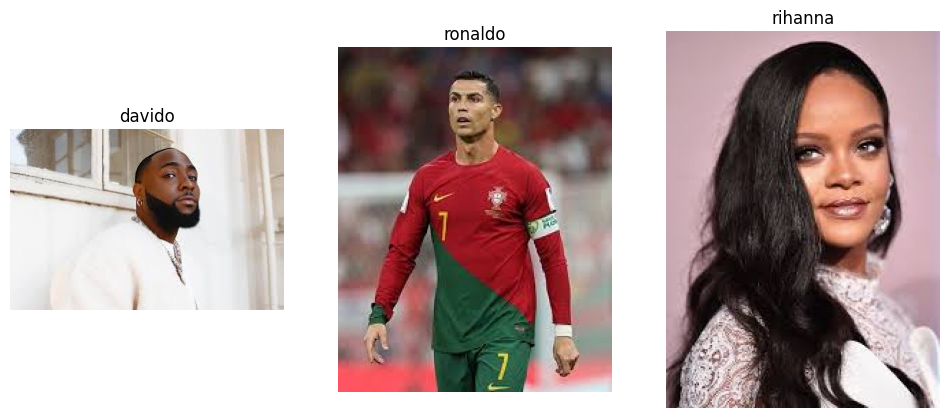

In [4]:
if not os.path.exists(image_folder_path):
    print(f"Error: Folder not found at {image_folder_path}")
else:
    class_folders = os.listdir(image_folder_path)

    dataset = []
    class_images = {}

    for class_name in class_folders:
        class_path = os.path.join(image_folder_path, class_name)
        if os.path.isdir(class_path):  # ensure it's a folder
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            full_paths = [os.path.join(class_path, f) for f in image_files]
            dataset.extend([(path, class_name) for path in full_paths])
            class_images[class_name] = full_paths  # store for preview

    # Print summary
    print(f"Total images found: {len(dataset)}")

    # Preview one random image per class
    plt.figure(figsize=(12, 6))
    for i, (class_name, paths) in enumerate(class_images.items()):
        if paths:  # check folder not empty
            sample_path = random.choice(paths)
            img = mpimg.imread(sample_path)
            plt.subplot(1, len(class_images), i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
    plt.show()


In [9]:
data_dir = '/content/drive/My Drive/images_class/'
batch_size = 8
num_classes = 3

# Data augmentation (train) + normalization
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Train / Val split (80/20)
train_dataset = datasets.ImageFolder(data_dir, transform=data_transforms["train"])
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer with new classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, num_classes)
)

model = model.to(device)

Using device: cpu


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        acc = correct / total * 100

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f} "
              f"Val Loss: {val_loss/len(val_loader):.4f} "
              f"Val Acc: {acc:.2f}%")

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20] Train Loss: 1.1558 Val Loss: 0.9726 Val Acc: 100.00%
Epoch [2/20] Train Loss: 1.1675 Val Loss: 0.9208 Val Acc: 83.33%
Epoch [3/20] Train Loss: 1.1105 Val Loss: 0.9329 Val Acc: 66.67%
Epoch [4/20] Train Loss: 1.0448 Val Loss: 0.8794 Val Acc: 83.33%
Epoch [5/20] Train Loss: 0.9353 Val Loss: 0.8139 Val Acc: 83.33%
Epoch [6/20] Train Loss: 0.8721 Val Loss: 0.7203 Val Acc: 83.33%
Epoch [7/20] Train Loss: 0.7535 Val Loss: 0.5592 Val Acc: 83.33%
Epoch [8/20] Train Loss: 0.7387 Val Loss: 0.4405 Val Acc: 100.00%
Epoch [9/20] Train Loss: 0.7306 Val Loss: 0.3113 Val Acc: 100.00%
Epoch [10/20] Train Loss: 0.7398 Val Loss: 0.4872 Val Acc: 83.33%
Epoch [11/20] Train Loss: 0.5563 Val Loss: 0.3857 Val Acc: 83.33%
Epoch [12/20] Train Loss: 0.5362 Val Loss: 0.4161 Val Acc: 83.33%
Epoch [13/20] Train Loss: 0.4914 Val Loss: 0.3611 Val Acc: 100.00%
Epoch [14/20] Train Loss: 0.3913 Val Loss: 0.4349 Val Acc: 83.33%
Epoch [15/20] Train Loss: 0.4726 Val Loss: 0.4575 Val Acc: 83.33%
Epoch [16/20] T

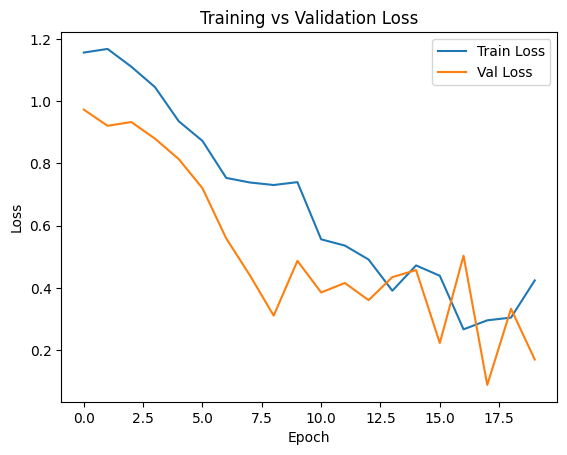

In [13]:

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

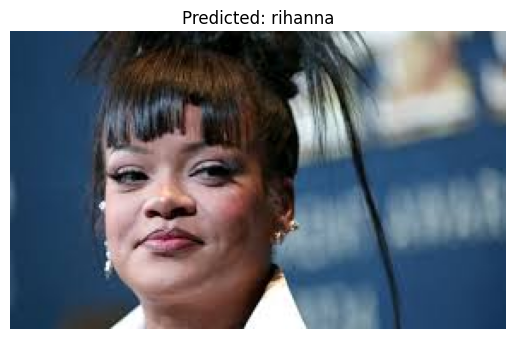

Model Prediction: rihanna


In [15]:
from PIL import Image

def predict_image(image_path, model, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Show image + prediction
    plt.imshow(np.array(image))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class


# Example usage:
class_names = train_dataset.classes  # ['davido', 'rihanna', 'ronaldo']
test_image_path = "/content/image.jpeg"  # change to your image path
prediction = predict_image(test_image_path, model, class_names)
print("Model Prediction:", prediction)

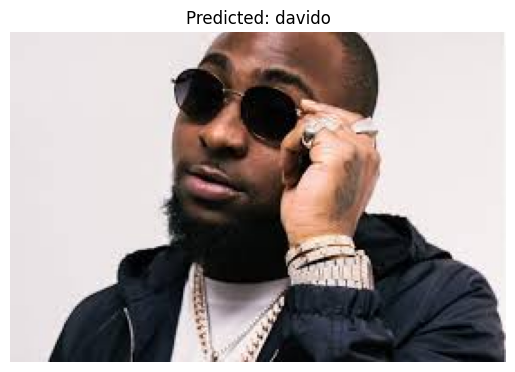

Model Prediction: davido


In [16]:
from PIL import Image

def predict_image(image_path, model, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Show image + prediction
    plt.imshow(np.array(image))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class



class_names = train_dataset.classes  # ['davido', 'rihanna', 'ronaldo']
test_image_path = "/content/images.jpeg"
prediction = predict_image(test_image_path, model, class_names)
print("Model Prediction:", prediction)

In [17]:

train_data = datasets.ImageFolder("/content/drive/My Drive/images_class/")
print(train_data.class_to_idx)
print(train_data.classes)

{'davido': 0, 'rihanna': 1, 'ronaldo': 2}
['davido', 'rihanna', 'ronaldo']


In [18]:
# Save the full model (including architecture and state dictionary)
full_model_save_path = '/content/image_classification_full_model.pth'
torch.save(model, full_model_save_path)
print(f"Full model saved to {full_model_save_path}")

Full model saved to /content/image_classification_full_model.pth


In [19]:
# Save the model
model_save_path = '/content/image_classification_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/image_classification_model.pth


In [20]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a SummaryWriter to log metrics
log_dir = "./runs/image_classification_experiment"  # Directory for TensorBoard logs
writer = SummaryWriter(log_dir)

# Training Loop with TensorBoard Logging
def train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_loss = float("inf")
    patience = 5  # Early stopping patience
    counter = 0 # Early stopping counter

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Log training loss to TensorBoard
            writer.add_scalar('Loss/Train_step', loss.item(), epoch * len(train_loader) + i)


        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total

        # Log epoch training loss and accuracy
        writer.add_scalar('Loss/Train_epoch', epoch_train_loss, epoch)
        writer.add_scalar('Accuracy/Train_epoch', epoch_train_acc, epoch)


        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total

        # Log epoch validation loss and accuracy
        writer.add_scalar('Loss/Val_epoch', epoch_val_loss, epoch)
        writer.add_scalar('Accuracy/Val_epoch', epoch_val_acc, epoch)


        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} "
              f"Train Acc: {epoch_train_acc:.2f}% "
              f"Val Loss: {epoch_val_loss:.4f} "
              f"Val Acc: {epoch_val_acc:.2f}%")

        # Scheduler step
        scheduler.step()

        # --- Early Stopping check ---
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            # Save the best model state dictionary
            torch.save(model.state_dict(), "best_model.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    writer.close() # Close the SummaryWriter

# Assuming 'model', 'train_loader', 'val_loader', 'criterion', 'optimizer', and 'scheduler' are already defined.
# You can call the new training function like this:
# train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

In [24]:
# Define the scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Call the training function
train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, scheduler , num_epochs=20)

Epoch [1/20] Train Loss: 0.3479 Train Acc: 85.19% Val Loss: 0.6187 Val Acc: 83.33%
Epoch [2/20] Train Loss: 0.3883 Train Acc: 87.04% Val Loss: 0.5236 Val Acc: 83.33%
Epoch [3/20] Train Loss: 0.3941 Train Acc: 83.33% Val Loss: 0.0925 Val Acc: 100.00%
Epoch [4/20] Train Loss: 0.2851 Train Acc: 88.89% Val Loss: 0.2615 Val Acc: 83.33%
Epoch [5/20] Train Loss: 0.3632 Train Acc: 85.19% Val Loss: 0.3278 Val Acc: 83.33%
Epoch [6/20] Train Loss: 0.3790 Train Acc: 87.04% Val Loss: 0.2966 Val Acc: 83.33%
Epoch [7/20] Train Loss: 0.3640 Train Acc: 87.04% Val Loss: 0.3558 Val Acc: 83.33%
Epoch [8/20] Train Loss: 0.2336 Train Acc: 94.44% Val Loss: 0.1422 Val Acc: 100.00%
⏹️ Early stopping triggered.
